In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from  process import *

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
train = pd.read_parquet(Path('../data/preprocessed/train.pq'))
test = pd.read_parquet(Path('../data/preprocessed/test.pq'))

In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Начинаем докидывать данные

In [6]:
# Добавляем Locality от Ивана
train['loc_enc'] = train["locality"].astype(str).str[8:11] 
train['loc_enc'] = train['loc_enc'].apply(lambda x: "0" if len(x)!=3 else x)

test['loc_enc'] = test["locality"].astype(str).str[8:11] 
test['loc_enc'] = test['loc_enc'].apply(lambda x: "0" if len(x)!=3 else x)

CAT_FEATURES += ['loc_enc']
CAT_FEATURES = list(set(CAT_FEATURES))

In [7]:
# Добавляем региональные фичи от Ивана
region_code_features = pd.read_csv(Path('../data/external/region_code_features.csv')) 
train = train.merge(region_code_features, on="region", how="left")
test = test.merge(region_code_features, on="region", how="left")

In [8]:
for col in ['rfs', 'rts', 'rr_k', 'rr_cl',
            'tfs', 'tts', 'tr_k', 'tr_cl',
            'gfs', 'gts', 'gr_k', 'gr_cl',
            'rrfs', 'rrts', 'rrr_k', 'rrr_cl']:
    if col.endswith("_cl"):
        train.loc[:, col] = train.loc[:, col].fillna(-1)
        test.loc[:, col] = test.loc[:, col].fillna(-1)
    else:
        median = train.loc[:, col].median()
        train.loc[:, col] = train.loc[:, col].fillna(median)
        test.loc[:, col] = test.loc[:, col].fillna(median)

In [9]:
# Добавляем образовательные фичи от Ивана
agg_education_mult = pd.read_csv(Path('../data/external/agg_education_mult.csv'))
train = train.merge(agg_education_mult, on="id", how="left")
train.loc[:, ["ins_all", "ins_diff", "year_min", "year_max"]] = \
    train.loc[:, ["ins_all", "ins_diff", "year_min", "year_max"]].fillna(-1)
test = test.merge(agg_education_mult, on="id", how="left")
test.loc[:, ["ins_all", "ins_diff", "year_min", "year_max"]] = \
    test.loc[:, ["ins_all", "ins_diff", "year_min", "year_max"]].fillna(-1)

In [10]:
# Добавляем фичи от Кати
cols = ['city', 'city_population', 'adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city']
cities = pd.read_csv(Path('../data/external/city_features.csv'))
cities.columns = ['city', 'city_population', 'adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city']


In [11]:
train = train.merge(cities, how='left', left_on='locality_name', right_on='city')
test = test.merge(cities, how='left', left_on='locality_name', right_on='city')

In [12]:
train.loc[:, ['city_population', 'adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city']] = \
    train.loc[:, ['city_population', 'adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city']].fillna(-1)
test.loc[:, ['city_population', 'adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city']] = \
    test.loc[:, ['city_population', 'adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city']].fillna(-1)

In [13]:
train.drop(columns=['city'], inplace = True)
test.drop(columns=['city'], inplace = True)

In [14]:
train.drop(columns=['adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city'], inplace = True)
test.drop(columns=['adm_center',
       'is_million', 'hugest_city', 'huge_city',
       'big_city', 'avg_city'], inplace = True)

In [15]:
def merge_macro(df, macro):
    df = df.copy()
    df['publish_year'] = pd.to_datetime(df.modification_date).dt.year
    df['publish_month'] = pd.to_datetime(df.modification_date).dt.month
    return df.merge(macro, left_on=['publish_year', 'publish_month', 'region'], 
                       right_on=['Год', 'Месяц', 'Регион'], how='left').\
                       drop(['Год', 'Месяц', 'Регион', 'Квартал'], axis=1).drop(
        columns=['publish_year', 'publish_month'])

In [ ]:
# def data_merge(df, ext_df, suffix):
#     ext_df = ext_df.copy()
#     ext_df.columns = [f'{c}{suffix}'  if c != 'id' else c for c in ext_df.columns]
#     df['publish_year'] = pd.to_datetime(df.publish_date).dt.year.astype(str)
#     df['publish_month'] = pd.to_datetime(df.publish_date).dt.month.astype(str)
#     return df.merge(ext_df, how='left', on='id')

In [16]:
macro = pd.read_csv(Path('../data/external/macro_region_features.csv'))

In [18]:
train = merge_macro(train, macro)
test = merge_macro(test, macro)

In [19]:
train.loc[:, ['МРОТ_бюджетная_сфера',
       'МРОТ_внебюджетная_сфера', 'Регистрируемая_безработица',
       'Общая_безработица', 'Рабочая_сила', 'Уровень_цен',
       'Минимальный_районный_коэффициент', 'Максимальный_районный_коэффициент',
       'Площадь_региона', 'Доля_городского_населения', 'Количество_юр_лиц']] = \
    train.loc[:, ['МРОТ_бюджетная_сфера',
       'МРОТ_внебюджетная_сфера', 'Регистрируемая_безработица',
       'Общая_безработица', 'Рабочая_сила', 'Уровень_цен',
       'Минимальный_районный_коэффициент', 'Максимальный_районный_коэффициент',
       'Площадь_региона', 'Доля_городского_населения', 'Количество_юр_лиц']].fillna(-1)
test.loc[:, ['МРОТ_бюджетная_сфера',
       'МРОТ_внебюджетная_сфера', 'Регистрируемая_безработица',
       'Общая_безработица', 'Рабочая_сила', 'Уровень_цен',
       'Минимальный_районный_коэффициент', 'Максимальный_районный_коэффициент',
       'Площадь_региона', 'Доля_городского_населения', 'Количество_юр_лиц']] = \
    test.loc[:, ['МРОТ_бюджетная_сфера',
       'МРОТ_внебюджетная_сфера', 'Регистрируемая_безработица',
       'Общая_безработица', 'Рабочая_сила', 'Уровень_цен',
       'Минимальный_районный_коэффициент', 'Максимальный_районный_коэффициент',
       'Площадь_региона', 'Доля_городского_населения', 'Количество_юр_лиц']].fillna(-1)

In [20]:
work_gr = pd.read_csv(Path('../data/external/work_gr.csv'))
train = train.merge(work_gr, on="id", how="left")
test = test.merge(work_gr, on="id", how="left")
work_cols = ["pos_count", "pos_uniq", "emp_uniq", "day_exp", "day_free"]
test.loc[:, work_cols] = test.loc[:, work_cols].fillna(-1)
train.loc[:, work_cols] = train.loc[:, work_cols].fillna(-1)

In [21]:
train.isnull().sum()

id                                        0
position                                  0
region                                    0
industry                                  0
locality                                  0
locality_name                             0
education_type                            0
drive_licences                            0
citizenship                               0
schedule                                  0
employement_type                          0
age                                       0
gender                                    0
experience                                0
salary_desired                            0
relocation_ready                          0
travel_ready                              0
retraining_ready                          0
is_worldskills_participant                0
has_qualifications                        0
completeness_rate                         0
creation_date                             7
modification_date               

In [22]:
train_n = train.drop(columns=DROP_FEATURES)
test_n = test.drop(columns=DROP_FEATURES)

In [23]:
X_train, X_val = train_test_split(train_n.drop(columns=['id']), train_size=0.7, random_state=42)

In [24]:
X_train = X_train[X_train.salary > 0].copy()

In [25]:
set(CAT_FEATURES) - set(train_n.columns)

set()

In [26]:
train_pool = Pool(X_train.drop(columns=['salary']), np.log(X_train['salary']+1), cat_features=CAT_FEATURES)

In [27]:
val_pool = Pool(X_val.drop(columns=['salary']), np.log(X_val['salary']+1), cat_features=CAT_FEATURES)

In [28]:
est = CatBoostRegressor(random_state=42, 
                        task_type="GPU", 
#                         objective="Tweedie:variance_power=1.5", 
                        objective="RMSE",
#                         eval_metric="MSLE"
                        n_estimators=1000
                       )

In [29]:
est.fit(train_pool, eval_set=val_pool, verbose_eval=100)

Learning rate set to 0.168094
0:	learn: 0.5784032	test: 1.0844978	best: 1.0844978 (0)	total: 55.8ms	remaining: 55.8s
100:	learn: 0.4319428	test: 1.0144280	best: 1.0144280 (100)	total: 5.62s	remaining: 50s
200:	learn: 0.4260142	test: 1.0123210	best: 1.0123210 (200)	total: 11.4s	remaining: 45.4s
300:	learn: 0.4228507	test: 1.0116159	best: 1.0116159 (300)	total: 17.2s	remaining: 40s
400:	learn: 0.4205292	test: 1.0112039	best: 1.0112039 (400)	total: 23.1s	remaining: 34.5s
500:	learn: 0.4190904	test: 1.0110958	best: 1.0110858 (477)	total: 28.9s	remaining: 28.8s
600:	learn: 0.4179501	test: 1.0109830	best: 1.0109702 (587)	total: 34.7s	remaining: 23s
700:	learn: 0.4166944	test: 1.0108519	best: 1.0108491 (697)	total: 40.7s	remaining: 17.4s
800:	learn: 0.4155112	test: 1.0107464	best: 1.0107137 (776)	total: 46.6s	remaining: 11.6s
900:	learn: 0.4144454	test: 1.0106932	best: 1.0106842 (897)	total: 52.6s	remaining: 5.78s
999:	learn: 0.4134505	test: 1.0106590	best: 1.0106210 (953)	total: 58.4s	remain

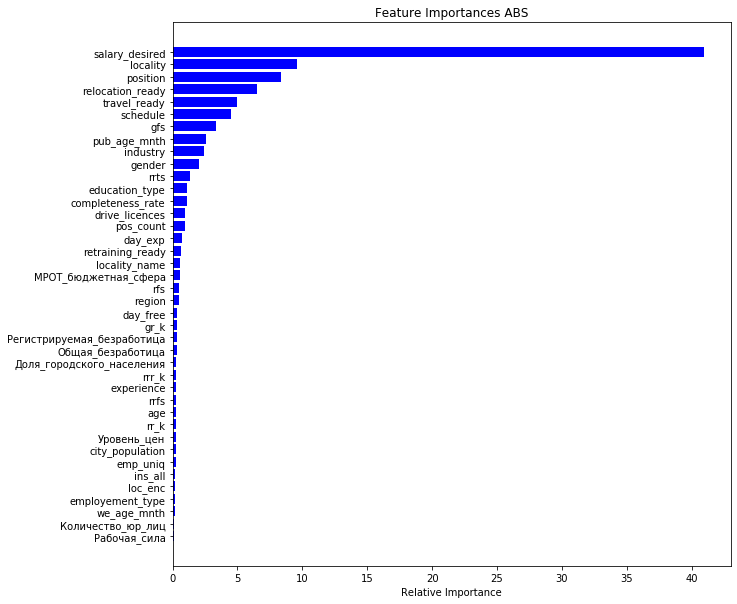

In [30]:
importance = sorted(zip(X_train.drop(columns=['salary']).columns, est.feature_importances_), key=lambda x: x[1], reverse=True)
imp = list(reversed(importance[:40]))
plt.figure(figsize=(10,10))
plt.title('Feature Importances ABS')
plt.barh(range(len(imp)), [x[1] for x in imp], color='b', align='center')
plt.yticks(range(len(imp)), [x[0] for x in imp])
plt.xlabel('Relative Importance')
plt.show()

In [31]:
np.sqrt(mean_squared_log_error(X_val['salary'], np.exp(est.predict(val_pool))-1))

1.01062137770975

* 1.0002459540809223
* 0.9989720927549951
* 0.999892639641595
* Last best is 1.0013057978090611

In [32]:
np.sqrt(mean_squared_log_error(X_train['salary'], np.exp(est.predict(train_pool))-1))

0.387861470034614

* 0.9782895609871397
* 0.9617807300376762
* 0.9670232079275483
* Last best is 0.9706161322898464

In [33]:
train_n_z = train_n[train_n.salary > 0].copy()

In [34]:
est.fit(train_n_z.drop(columns=['id', 'salary']), 
        np.log(train_n_z['salary']+1), 
        verbose_eval=100,
       cat_features=CAT_FEATURES)

Learning rate set to 0.164987
0:	learn: 0.5788880	total: 79.6ms	remaining: 1m 19s
100:	learn: 0.4328531	total: 6.39s	remaining: 56.9s
200:	learn: 0.4273089	total: 13s	remaining: 51.7s
300:	learn: 0.4246445	total: 19.5s	remaining: 45.4s
400:	learn: 0.4226135	total: 26.2s	remaining: 39.1s
500:	learn: 0.4210860	total: 32.7s	remaining: 32.6s
600:	learn: 0.4197916	total: 39.4s	remaining: 26.1s
700:	learn: 0.4187274	total: 46.1s	remaining: 19.7s
800:	learn: 0.4177021	total: 52.8s	remaining: 13.1s
900:	learn: 0.4167536	total: 59.6s	remaining: 6.55s
999:	learn: 0.4158898	total: 1m 6s	remaining: 0us


In [35]:
np.sqrt(mean_squared_log_error(train_n_z['salary'], 
                               np.exp(est.predict(train_n_z.drop(columns=['id', 'salary'])))-1))

0.38674707260956603

* 0.9759966198964987
* 0.9624461592641188
* Last best is 0.959510799941904

In [36]:
predict=np.exp(est.predict(test_n.drop(columns=['id'])))-1

In [37]:
sub = test_n[['id']].copy()

In [38]:
sub['salary'] = predict

In [39]:
sub.to_csv(Path('../submissions/cb_3_zeros_out_sub.csv'), index=False, sep=",")